# Loading necessary Libraries

In [175]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style

# Loading Dataset

In [176]:
# Reading Data # First Column is the index
df = pd.read_csv('../00_Data/online_retailed_precleaned.csv', index_col=0)

In [178]:
# First five rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Num_word_text
0,536365,3249,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,4048,United Kingdom,5
1,536365,2649,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,4048,United Kingdom,3
2,536365,2855,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,4048,United Kingdom,5
3,536365,2803,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,4048,United Kingdom,6
4,536365,2802,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,4048,United Kingdom,5


In [217]:
# Shape of data
df.shape

(396528, 10)

In [219]:
# Unique Users & Items
print("Unique Users:", df.CustomerID.nunique())
print("Unique Items:", df.StockCode.nunique())

Unique Users: 3696
Unique Items: 2786


# Preparation: Binary Dataset

Main Steps

1. Remove all cancelled orders
2. Aggregate all User - Item Interactions & Create Flag Column for Purchases
3. Split into Train & Test Data

# 1. Removing Cancelled Orders

In [179]:
# Filter out rows with cancelled orders
df_non_cancelled = df[~df['InvoiceNo'].str.startswith('C')]

In [180]:
# Check Shape after Removal
df_non_cancelled.shape

(388422, 9)

In [220]:
# Number of removed rows
df.shape[0] - df_non_cancelled.shape[0]

8106

In [222]:
# Unique Users & Items
print("Unique Users:", df.CustomerID.nunique())
print("Unique Items:", df.StockCode.nunique())

Unique Users: 3696
Unique Items: 2786


# 2. Aggregate User - Item Interactions - Create Flag Column for Purchased Items

In [181]:
# Calculate Count of all non-cancelled interactions between Users & Items
df_binary = df_non_cancelled.groupby(['StockCode', 'CustomerID']).agg({'CustomerID': 'count'})

# Rename Columns 
df_binary.columns = ['purchased']

# Reset Index
df_binary.reset_index(inplace=True)

# Set all purchases to 1 
df_binary['purchased'] = 1 

# Check first five columns
df_binary.head()

,StockCode,CustomerID,purchased
0,0,86,1
1,0,132,1
2,0,191,1
3,0,238,1
4,0,270,1


In [182]:
# Sanity Check 
df_binary.purchased.describe()

count    259350.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: purchased, dtype: float64

In [183]:
# Print Unique Users & Items for Sanity Check  
print("Users: \t",df_binary['CustomerID'].nunique())
print("Items: \t",df_binary['StockCode'].nunique())

Users: 	 3694
Items: 	 2786


# 3. Split into Train & Test Data

In [184]:
# Load the Python Splitter
from recommenders.datasets.python_splitters import python_stratified_split

In [185]:
train, test = python_stratified_split(df_binary, ratio=0.8, filter_by='user', min_rating=10, col_user='CustomerID', col_item='StockCode', seed=1)
#train, test = train_test_split(df_binary, random_state=1, test_size=0.25)

In [186]:
# Sanity Check number of unique Users & Items in Train
print("Users Train: \t",train['CustomerID'].nunique())
print("Items Train: \t",train['StockCode'].nunique())
# Sanity Check number of unique Users & Items in Test
print("Users Test: \t",test['CustomerID'].nunique())
print("Items Test: \t",test['StockCode'].nunique())

Users Train: 	 3690
Items Train: 	 2786
Users Test: 	 3690
Items Test: 	 2746


In [187]:
# Ensure that the same items and users are in both sets 
# Find the set of unique items in both the train and test sets
train_items = set(train['StockCode'].unique())
test_items = set(test['StockCode'].unique())

# Find the intersection of the sets from step 1
common_items = train_items.intersection(test_items)

# Filter the train and test sets to include only the rows with item IDs that are in the intersection set
train = train[train['StockCode'].isin(common_items)]
test = test[test['StockCode'].isin(common_items)]

In [188]:
# Sanity Check number of unique Users & Items in Train
print("Users Train: \t",train['CustomerID'].nunique())
print("Items Train: \t",train['StockCode'].nunique())
# Sanity Check number of unique Users & Items in Test
print("Users Test: \t",test['CustomerID'].nunique())
print("Items Test: \t",test['StockCode'].nunique())

Users Train: 	 3690
Items Train: 	 2746
Users Test: 	 3690
Items Test: 	 2746


In [189]:
# Shapes to Check 
print("Shape of Train:", train.shape)
print("Shape of Test: \t", test.shape)

Shape of Train: (206861, 3)
Shape of Test: 	 (51879, 3)


In [221]:
# All rows
train.shape[0] + test.shape[0]

258740

In [190]:
# Save as csv 
train.to_csv('../00_Data/online_retail_train.csv')
test.to_csv('../00_Data/online_retail_test.csv')


# Preparation: Pseudo-Rating Dataset

**Main Steps**

1. Create a flag column for purchased items
2. Decrease value of cancelled purchases 
3. Filter out cancelled combinations from initial Dataset
4. Increase value of repurchased items
5. Insert negative value for non-purchased popular items
6. Split into Train & Test Data

In [191]:
# Reading Data Again since it was changed above
df = pd.read_csv('../00_Data/online_retailed_precleaned.csv', index_col=0)

## 1. Flag Column for purchased items:

In [192]:
# Create column 'purchased' and assign the value 1 for each row
df['purchased'] = 1 

# Check First 5 Rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Num_word_text,purchased
0,536365,3249,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,4048,United Kingdom,5,1
1,536365,2649,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,4048,United Kingdom,3,1
2,536365,2855,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,4048,United Kingdom,5,1
3,536365,2803,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,4048,United Kingdom,6,1
4,536365,2802,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,4048,United Kingdom,5,1


## 2. Decrease value of cancelled purchases 

In [193]:
# First find out Cancelled orders 
# Rows that start with a C in InvoiceNo 
df_cancellations = df[df.InvoiceNo.str[0]=='C']

# Check Head for Sanity
df_cancellations.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Num_word_text,purchased
154,C536383,2407,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,2192,United Kingdom,6,1
235,C536391,1415,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,3829,United Kingdom,5,1
236,C536391,919,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,3829,United Kingdom,6,1
237,C536391,918,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,3829,United Kingdom,6,1
238,C536391,915,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,3829,United Kingdom,6,1
239,C536391,604,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,3829,United Kingdom,5,1
240,C536391,1416,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,3829,United Kingdom,5,1
241,C536391,1412,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,3829,United Kingdom,4,1
939,C536506,1805,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,4088,United Kingdom,5,1
1441,C536543,1489,HAND WARMER RED RETROSPOT,-1,2010-12-01 14:30:00,2.10,4042,United Kingdom,4,1


In [223]:
# How many cancellations in general?
df_cancellations.shape

(8106, 10)

In [194]:
# Filter out unique combination of StockCode & Customer for cancelled Orders 
# Create DataFrmmae
df_cancelled = df_cancellations.groupby(['StockCode', 'CustomerID']).agg({'CustomerID': 'count'})

# Rename the columns
df_cancelled.columns = ['purchased']

# Reset the index
df_cancelled.reset_index(inplace=True)

# Change all cancelled Purchases to -2 
df_cancelled['purchased'] = -2

# Sanity Check with Describe
df_cancelled.describe()

,StockCode,CustomerID,purchased
count,7165.000000,7165.000000,7165.0
mean,1590.041870,1965.855687,-2.0
std,776.626005,1251.294089,0.0
min,7.000000,5.000000,-2.0
25%,1065.000000,869.000000,-2.0
50%,1576.000000,1863.000000,-2.0
75%,2036.000000,2995.000000,-2.0
max,3677.000000,4369.000000,-2.0


In [195]:
# Sample of df_cancelled
df_cancelled.sample(5)

,StockCode,CustomerID,purchased
2608,1301,187,-2
5434,2043,170,-2
2029,1123,2077,-2
6079,2337,2425,-2
2931,1427,1537,-2


## 3. Filter Out cancelled Combinations from Initial Dataset & Concat Cancelled orders to new Dataset

In [196]:
# Perform the anti join by merging on 'StockCode' and 'CustomerID' using a 'left' join and adding an '_merge' indicator column
merged_df = df.merge(df_cancelled, on=['StockCode', 'CustomerID'], how='left', indicator=True)

# Keep only the rows where the '_merge' indicator is 'left_only', meaning they only exist in the 'df' dataframe
filtered_df = merged_df[merged_df['_merge'] == 'left_only']

# Drop the '_merge' column and any additional columns from 'df_cancelled' that might have been added during the merge
filtered_df = filtered_df.drop(columns=['_merge'])

# Reset the index if needed
filtered_df.reset_index(drop=True, inplace=True)


In [229]:
# How many rows were in both 
merged_df[merged_df['_merge']=='both']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Num_word_text,purchased_x,purchased_y,_merge
6,536365,755,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,4048,United Kingdom,5,1,-2.0,both
8,536366,1489,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,4048,United Kingdom,5,1,-2.0,both
14,536367,3124,BOX OF 6 ASSORTED COLOUR TEASPOONS,6,2010-12-01 08:34:00,4.25,540,United Kingdom,6,1,-2.0,both
45,536372,1489,HAND WARMER RED POLKA DOT,6,2010-12-01 09:01:00,1.85,4048,United Kingdom,5,1,-2.0,both
52,536373,842,SAVE THE PLANET MUG,6,2010-12-01 09:02:00,1.06,4048,United Kingdom,4,1,-2.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...
396448,581579,986,PAPER CHAIN KIT RETROSPOT,6,2011-12-09 12:19:00,2.95,3854,United Kingdom,4,1,-2.0,both
396452,581579,2165,JUMBO BAG VINTAGE CHRISTMAS,30,2011-12-09 12:19:00,1.79,3854,United Kingdom,4,1,-2.0,both
396490,581585,1073,VICTORIAN GLASS HANGING T-LIGHT,12,2011-12-09 12:31:00,1.95,2562,United Kingdom,4,1,-2.0,both
396495,581585,3106,MULTI COLOUR SILVER T-LIGHT HOLDER,24,2011-12-09 12:31:00,0.85,2562,United Kingdom,5,1,-2.0,both


In [230]:
# How many rows after removing initials order of cancelled transactions 
filtered_df.shape

(371177, 11)

In [197]:
# Group by InvoiceNo and calculate the number of appearances and the product of Quantity and UnitPrice
df_purchased = filtered_df.groupby(['StockCode', 'CustomerID']).agg({'CustomerID': 'count'})

# Rename the columns
df_purchased.columns = ['purchased']

# Reset the index
df_purchased.reset_index(inplace=True)

# Sanity Check with Describe
df_purchased.head()

,StockCode,CustomerID,purchased
0,0,86,1
1,0,132,1
2,0,191,1
3,0,238,1
4,0,270,1


In [198]:
# Concatenate Purched & Cancelled
df_ratings = pd.concat([df_purchased, df_cancelled], ignore_index=True)

# Check Shape
print(df_ratings.shape)

# First five Rews
df_ratings.head()

(259896, 3)


,StockCode,CustomerID,purchased
0,0,86,1
1,0,132,1
2,0,191,1
3,0,238,1
4,0,270,1


In [199]:
# Describe df_ratings
df_ratings.describe()

,StockCode,CustomerID,purchased
count,259896.000000,259896.000000,259896.000000
mean,1563.001739,2170.848651,1.373038
std,813.517872,1251.674405,1.378517
min,0.000000,1.000000,-2.000000
25%,953.000000,1136.000000,1.000000
50%,1539.000000,2130.000000,1.000000
75%,2100.000000,3272.000000,1.000000
max,3677.000000,4371.000000,54.000000


In [233]:
# Unique Users & Items
print("Unique Users:", df_ratings.CustomerID.nunique())
print("Unique Items:", df_ratings.StockCode.nunique())

Unique Users: 3696
Unique Items: 2786


## 4. Increase value of repurchased items

In [200]:
# Apply function with lambda for the condition: If x in purchased <=1 x, else 2 
df_ratings['purchased'] = df_ratings['purchased'].apply(lambda x: x if x <= 1 else 2)

# Check
df_ratings.purchased.value_counts()



 1    191863
 2     60868
-2      7165
Name: purchased, dtype: int64

## 5. Insert Negative Values for non Purchased Popular Items

In [201]:
# First remove cancellations from initial
df_positive = df[~df['InvoiceNo'].str.startswith('C')]

# Second Count number of Purchases per Item
df_items = df_positive.groupby('StockCode').agg({'StockCode': 'count'})

# Rename the columns
df_items.columns = ['Purchases']

# Reset the index
df_items.reset_index(inplace=True)

df_items.head()


,StockCode,Purchases
0,0,49
1,1,21
2,2,30
3,6,64
4,7,123


In [202]:
# Filter Out best Items 
df_top5_items = df_items[df_items['Purchases'] >= df_items['Purchases'].quantile(0.98)]

# Number of top Items 
df_top5_items.shape[0]

58

In [203]:
# Save top Items in an array 
top5_perc_items = df_top5_items['StockCode'].unique()

# Save all Users from df_rating in an array
all_users = df_ratings['CustomerID'].unique()

In [204]:
# For sanity check in the next step multiply length of both arrays. This should later be the shape of dataframe with unique combinations out of both arrays
len(top5_perc_items) * len(all_users)

214368

In [205]:
# Create Dataframe with all unique matches of top items and all users 

# First Create a meshgrid of all_users and top5_perc_items
user_grid, item_grid = np.meshgrid(all_users, top5_perc_items, indexing='ij')

# Flatten the meshgrid arrays
user_flat = user_grid.flatten()
item_flat = item_grid.flatten()

# Create a pandas dataframe with a row for each combination of the values in all_users and top5_perc_items
top_potential_purchases = pd.DataFrame({'CustomerID': user_flat, 'StockCode': item_flat})

# Check shape: it should be 510462 
top_potential_purchases.shape


(214368, 2)

In [206]:
# Insert a -1 in a new column as value for all rows
top_potential_purchases['purchased'] = -1 

# Sanity check
top_potential_purchases.head()

,CustomerID,StockCode,purchased
0,86,169,-1
1,86,170,-1
2,86,171,-1
3,86,172,-1
4,86,173,-1


In [207]:
# Perform an Anti-Join between df_ratings and top_potential_purchases to find out combinations of CustomerID & StockCode that are only in top_potential purchases. Drop duplicates and concatenate to ratings

# Perform the anti join by merging on 'StockCode' and 'CustomerID' using a 'left' join and adding an '_merge' indicator column
popular_non_bought = top_potential_purchases.merge(df_ratings, on=['StockCode', 'CustomerID'], how='left', indicator=True)

# Keep only the rows where the '_merge' indicator is 'left_only', meaning they only exist in the 'df' dataframe
popular_non_bought = popular_non_bought[popular_non_bought['_merge'] == 'left_only']

# Drop the '_merge' column and any additional columns from 'df_cancelled' that might have been added during the merge
popular_non_bought = popular_non_bought.drop(columns=['_merge', 'purchased_y'])

# Reset the index if needed
popular_non_bought.reset_index(drop=True, inplace=True)

# Rename purchased_x to purchased
popular_non_bought = popular_non_bought.rename(columns={'purchased_x':'purchased'})

# Show first Five rows
popular_non_bought.head()


,CustomerID,StockCode,purchased
0,86,315,-1
1,86,399,-1
2,86,401,-1
3,86,771,-1
4,86,791,-1


In [208]:
# Concatenate popular_non_bought with df_ratings
df_ratings = pd.concat([df_ratings, popular_non_bought], ignore_index=True)

# Check sample
df_ratings.sample(10)

,StockCode,CustomerID,purchased
434555,1520,3800,-1
263157,1486,3857,-1
274842,1336,1211,-1
284929,1806,613,-1
295632,1280,1110,-1
358604,2776,4003,-1
391418,1551,829,-1
407303,2033,2416,-1
240378,3126,1206,1
203226,2189,1233,1


In [209]:
# Check Descriptive Statistics
df_ratings.describe()

,StockCode,CustomerID,purchased
count,447393.000000,447393.000000,447393.000000
mean,1501.553469,2173.503302,0.249830
std,806.581551,1258.192015,1.180587
min,0.000000,1.000000,-2.000000
25%,969.000000,1109.000000,-1.000000
50%,1486.000000,2151.000000,1.000000
75%,2038.000000,3274.000000,1.000000
max,3677.000000,4371.000000,2.000000


In [210]:
# Check Distribution 
df_ratings.purchased.value_counts()

 1    191863
-1    187497
 2     60868
-2      7165
Name: purchased, dtype: int64

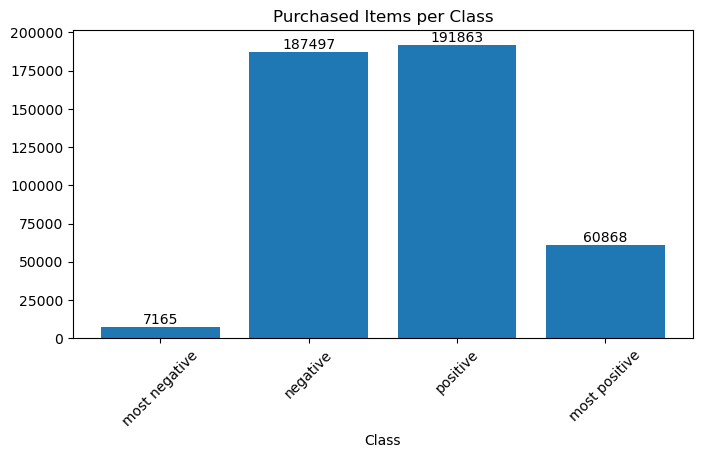

In [278]:
# Visualization 
dist_classes = pd.DataFrame(df_ratings.purchased.value_counts())
dist_classes.reset_index(inplace=True)
dist_classes.columns = ['class', 'purchased']

# Apply function with lambda for the condition:
dist_classes['class'] = dist_classes['class'].apply(lambda x: 4 if x == 2 else x)
dist_classes['class'] = dist_classes['class'].apply(lambda x: 3 if x == 1 else x)
dist_classes['class'] = dist_classes['class'].apply(lambda x: 2 if x == -1 else x)
dist_classes['class'] = dist_classes['class'].apply(lambda x: 1 if x == -2 else x)


import matplotlib.pyplot as plt

# Create a vertical bar chart
fig, ax = plt.subplots()
bars = ax.bar(dist_classes['class'], dist_classes['purchased'])

# Display the values on the graph
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

# Set labels and title
ax.set_xlabel('Class')
#ax.set_ylabel('Purchased')
ax.set_title('Purchased Items per Class')

# Set x-axis ticks with 4 steps from 1 to 4
ax.set_xticks(range(1, 5))

# Create a mapping dictionary for custom labels
class_labels = {
    1: 'most negative',
    2: 'negative',
    3: 'positive',
    4: 'most positive'
}

# Set custom x-axis labels and rotate them by 45 degrees
ax.set_xticklabels([class_labels[i] for i in range(1, 5)], rotation=45)

# Show the plot
plt.show()


## 6. Split Into Training & Test Data

In [235]:
# Df Ratings Shape before Split
df_ratings.shape

(447393, 3)

In [285]:
# Load the Chronological Splitter
from recommenders.datasets.python_splitters import python_stratified_split

# Load Train Test Split 
from sklearn.model_selection import train_test_split
# Split with Python Stratified
#train_rat, test_rat = python_stratified_split(df_ratings, ratio=0.8, filter_by='user', min_rating=10, col_user='CustomerID', col_item='StockCode', seed=1)
train_rat, test_rat = train_test_split(df_ratings, stratify=df_ratings.purchased, test_size=0.2)


In [286]:
# Rows in Train & Test
print("Rows in train:", train_rat.shape[0])
print("Rows in test:", test_rat.shape[0])

Rows in train: 357914
Rows in test: 89479


In [287]:
# Rows removed during train-test split
df_ratings.shape[0] - (train_rat.shape[0] +test_rat.shape[0])

0

In [301]:
(train_rat.shape[0] +test_rat.shape[0])

447171

In [288]:
# Ensure that the same items and users are in both sets 
# Find the set of unique items in both the train and test sets
train_items_rat = set(train_rat['StockCode'].unique())
test_items_rat = set(test_rat['StockCode'].unique())

# Find the intersection of the sets from step 1
common_items_rat = train_items_rat.intersection(test_items_rat)

# Filter the train and test sets to include only the rows with item IDs that are in the intersection set
train_rat = train_rat[train_rat['StockCode'].isin(common_items_rat)]
test_rat = test_rat[test_rat['StockCode'].isin(common_items_rat)]

In [289]:
#  Check number of unique Users & Items in Test & Train 
print("Users in Test:",test_rat['CustomerID'].nunique())
print("Users in Train:",train_rat['CustomerID'].nunique())
print("Items in Test:",test_rat['StockCode'].nunique())
print("Items in Train:",train_rat['StockCode'].nunique())


Users in Test: 3696
Users in Train: 3696
Items in Test: 2769
Items in Train: 2769


In [290]:
# Rows in Train & Test
print("Rows in train:", train_rat.shape[0])
print("Rows in test:", test_rat.shape[0])

Rows in train: 357692
Rows in test: 89479


In [295]:
# Save as csv 
train_rat.to_csv('../00_Data/online_retail_ratings_train.csv')
test_rat.to_csv('../00_Data/online_retail_ratings_test.csv')

In [292]:
train_rat.purchased.value_counts()

 1    153304
-1    149998
 2     48666
-2      5724
Name: purchased, dtype: int64

In [293]:
test_rat.purchased.value_counts()

 1    38373
-1    37499
 2    12174
-2     1433
Name: purchased, dtype: int64

[Text(0.5, 0, 'ratings'), Text(0, 0.5, 'density')]

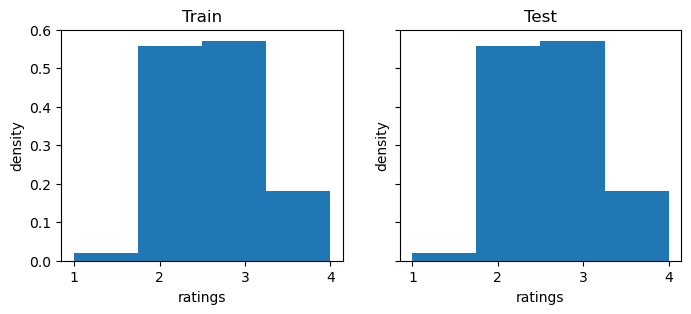

In [298]:
# Copy Train and Test 
train_rat_copy = train_rat.copy()
test_rat_copy = test_rat.copy() 

# Change values for Train
train_rat_copy['purchased'] = train_rat_copy['purchased'].apply(lambda x: 4 if x == 2 else x)
train_rat_copy['purchased'] = train_rat_copy['purchased'].apply(lambda x: 3 if x == 1 else x)
train_rat_copy['purchased'] = train_rat_copy['purchased'].apply(lambda x: 2 if x == -1 else x)
train_rat_copy['purchased'] = train_rat_copy['purchased'].apply(lambda x: 1 if x == -2 else x) 

# Change values for Test 
test_rat_copy['purchased'] = test_rat_copy['purchased'].apply(lambda x: 4 if x == 2 else x)
test_rat_copy['purchased'] = test_rat_copy['purchased'].apply(lambda x: 3 if x == 1 else x)
test_rat_copy['purchased'] = test_rat_copy['purchased'].apply(lambda x: 2 if x == -1 else x)
test_rat_copy['purchased'] = test_rat_copy['purchased'].apply(lambda x: 1 if x == -2 else x) 

# Density Histogram
_, (ax1m, ax2m) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1m.hist(train_rat_copy['purchased'], 4, density= True)
ax1m.set_title('Train')
ax1m.set(xlabel="ratings", ylabel="density")
ax2m.hist(test_rat_copy['purchased'], 4, density= True)
ax2m.set_title('Test')
ax2m.set(xlabel="ratings", ylabel="density")